In [30]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from scipy.spatial.distance import pdist, squareform

from fe_gmx import AWH_Ensemble, AWH_2D_Ensemble
from fe_gmx.utils.reweighting import plot_pmf

# import functions from epj_analysis.py (in tutorial/ANALYSIS)
# ln -s ~/tutorial/ANALYSIS/epj_analysis.py epj_analysis.py

from epj_analysis import (next_subunit_dict, prot_selections, prot_resids, chain_resids,
                          get_loopc_dynamics,
                          get_epj_contact,
                          get_water_dynamics,
                          get_sample_weight
)

In [2]:
import dask
from dask.distributed import Client, LocalCluster

In [3]:
from ENPMDA import MDDataFrame
from ENPMDA.preprocessing import TrajectoryEnsemble

In [4]:
awh_ensemble = AWH_2D_Ensemble('../AWH_2D_PORE_LOOPC', regenerate_awh=False)

Found 185 awh_pmf files.
The latest awh_pmf file is /nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/awh_result/awh_t368000.xvg
The latest awh_pmf file was generated at 2023-07-18 10:43:47
Found 8 walkers.
The latest walker was generated at 2023-07-17 10:44:20
Generating pulling data...
Generating log data...
Generating PMF data...


Generating PMF data: 100%|██████████| 185/185 [00:04<00:00, 46.04it/s]


In [6]:
awh_ensemble.awh_log[0]

AWH_LOG(filename=/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep1/awh.log, index=0), covering_times=[35420, 60200, 122580, 148800], equlibrated_histogram_time=35420, out_of_initial_stage_time=148800

In [8]:
generate_video=True
if generate_video:
    levels=np.linspace(0, 80, 20)

    awh_ensemble.generate_pmf_video(
                name='pmf',
                stride=1,
                remove_img=True,
                ffmpeg='/nethome/yzhuang/FFmpeg/ffmpeg',
                levels=levels,
                cv_labels=['Dist to Pore (nm)', 'Loop C (nm)'],
                pmf_label='PMF (kJ/mol)',
        )

100%|██████████| 185/185 [00:38<00:00,  4.75it/s]


ffmpeg version N-96086-g3530fdc78e Copyright (c) 2000-2019 the FFmpeg developers
built with gcc 7 (Ubuntu 7.4.0-1ubuntu1~18.04.1)
configuration: --disable-x86asm
libavutil      56. 36.101 / 56. 36.101
libavcodec     58. 65.100 / 58. 65.100
libavformat    58. 35.101 / 58. 35.101
libavdevice    58.  9.101 / 58.  9.101
libavfilter     7. 69.101 /  7. 69.101
libswscale      5.  6.100 /  5.  6.100
libswresample   3.  6.100 /  3.  6.100
Input #0, image2, from 'pmf_%d.png':
Duration: 00:00:37.00, start: 0.000000, bitrate: N/A
Stream #0:0: Video: png, rgba(pc), 700x900 [SAR 3937:3937 DAR 7:9], 5 fps, 5 tbr, 5 tbn, 5 tbc
Please use -b:a or -b:v, -b is ambiguous
Stream mapping:
Stream #0:0 -> #0:0 (png (native) -> mpeg4 (native))
Press [q] to stop, [?] for help
Output #0, mp4, to 'pmf.mp4':
Metadata:
encoder         : Lavf58.35.101
Stream #0:0: Video: mpeg4 (mp4v / 0x7634706D), yuv420p, 700x900 [SAR 1:1 DAR 7:9], q=2-31, 5000 kb/s, 30 fps, 15360 tbn, 30 tbc
Metadata:
encoder         : Lavc58.65.

In [9]:
cluster = LocalCluster(n_workers=16,
                       scheduler_port=8790,
                       memory_limit='4GB')

In [10]:
client = Client(cluster)

In [11]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 32,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8790,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:44191,Total threads: 2
Dashboard: http://127.0.0.1:32911/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:45263,


In [13]:
trajectory_list = []
topology_list = []
bonded_topology_list = []

In [14]:
awh_ensemble.rep_folder

['/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep1',
 '/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep2',
 '/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep3',
 '/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep4',
 '/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep5',
 '/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep6',
 '/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep7',
 '/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep8']

In [15]:
default_raw_load_location = os.getcwd()

for folder in awh_ensemble.rep_folder:
#    load_location = f'{default_raw_load_location}/{folder}'
    load_location = folder

    if not os.path.exists(load_location + '/../../start.pdb'):
        raise FileExistsError(load_location + '/../../start.pdb')
    trajectory_list.append(load_location +  "/awh.xtc")
    topology_list.append(load_location + '/../../start.pdb')
    bonded_topology_list.append(load_location + "/awh.tpr")

In [16]:
trajectory_ensemble = TrajectoryEnsemble(ensemble_name='loopc_epj_ensemble',
                                         trajectory_list=trajectory_list,
                                         topology_list=topology_list,
                                         bonded_topology_list=bonded_topology_list,
                                         skip=1,
                                         updating=True,
                                         only_raw=False,
                                         protein_selection='protein or resname EPJ'
                                         )
trajectory_ensemble.load_ensemble()

/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep1/awh.xtc on hold.
/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep2/awh.xtc on hold.
/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep3/awh.xtc on hold.
/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep4/awh.xtc on hold.
/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep5/awh.xtc on hold.
/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep6/awh.xtc on hold.
/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep7/awh.xtc on hold.
/nethome/yzhuang/cephfs/nachrs_modulator/AWH_2D/test/AWH_2D_PORE_LOOPC/rep8/awh.xtc on hold.
dask finished
pickle raw_traj universe done
dask finished
pickle traj protein universe done
dask finished
pickle traj system universe done


In [17]:
dataframe_name = 'epj_awh_pore_loopc'
md_dataframe = MDDataFrame(dataframe_name=dataframe_name)
md_dataframe.add_traj_ensemble(trajectory_ensemble,
                            npartitions=30,
                            stride=1)

Requested number of partitions:  30


In [18]:
print(f"Number of frames in the dataframe is {len(md_dataframe.dataframe)}")
print(f"dt in the dataframe is {md_dataframe.dataframe.traj_time.diff()[1] /1000} ns")
print(f"Number of systems in the dataframe is {len(md_dataframe.dataframe.system.unique())}")
print(f"Existing features are {md_dataframe.dataframe.columns}")

Number of frames in the dataframe is 29448
dt in the dataframe is 0.1 ns
Number of systems in the dataframe is 8
Existing features are Index(['universe_protein', 'universe_system', 'system', 'traj_name', 'frame',
       'traj_time', 'stride'],
      dtype='object')


In [19]:
u = mda.Universe('../start.pdb')

ag_lig_1 = u.select_atoms('resname EPJ').split('residue')[0]

prot_binding_site = u.select_atoms('name CA and byres (protein and around 4 group ag_lig_1)', ag_lig_1=ag_lig_1)

#sort prot_resids
chain_resids = prot_binding_site.segids[np.argsort(prot_binding_site.resids)]
prot_resids = np.sort(prot_binding_site.resids)

prot_resids = prot_resids[np.argsort(chain_resids)]
chain_resids = np.sort(chain_resids)

print(prot_resids)
print(chain_resids)

next_subunit_dict = {'A': 'C',
                     'B': 'D',
                     'C': 'E',
                     'D': 'F',
                     'E': 'G',
                     'F': 'H',
                     'G': 'I',
                     'H': 'J',
                     'I': 'A',
                     'J': 'B'}

prot_selections = []

for i in range(5):
    # only makes senses for homomers
    selection = 'protein and ('
    for j in range(prot_resids.shape[0]):
        # iterate subunit
        selection += f'(resid {prot_resids[j]} and segid {chain_resids[j]}) or '
        chain_resids[j] = next_subunit_dict[chain_resids[j]]
    selection = selection[:-4] + ')'
    prot_selections.append(selection)

[100 155 156 157 197 199 200 204  57  81 109 110 111 119 121]
['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'C' 'C' 'C' 'C' 'C' 'C' 'C']


In [19]:
md_dataframe.add_analysis(get_loopc_dynamics, overwrite=True)

Analysis loopC added


/nethome/yzhuang/git_repo/ENPMDA/ENPMDA/ENPMDA.py:241: UserWarning: The result of the analysis function is not 2D.Make sure the shape of feature info (5) does match the shape of analysis (5).
  self.analysis_results.add_column_to_results(analysis, **kwargs)
/nethome/yzhuang/anaconda3/envs/msm_dev/lib/python3.10/site-packages/distributed/client.py:3109: UserWarning: Sending large graph of size 13.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [20]:
md_dataframe.add_analysis(get_epj_contact, overwrite=True)

Analysis epj_contact added


/nethome/yzhuang/anaconda3/envs/msm_dev/lib/python3.10/site-packages/distributed/client.py:3109: UserWarning: Sending large graph of size 13.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [21]:
md_dataframe.add_analysis(get_water_dynamics, overwrite=True)

Analysis water added


/nethome/yzhuang/anaconda3/envs/msm_dev/lib/python3.10/site-packages/distributed/client.py:3109: UserWarning: Sending large graph of size 13.19 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [22]:
md_dataframe.sort_analysis_result()

Requested number of partitions:  30
start to sort loopC.
loopC sorted.
start to sort epj_contact.
epj_contact sorted.
start to sort water.
water sorted.
Requested number of partitions:  30


In [25]:
md_dataframe.save(dataframe_name)

In [12]:
dataframe_name = 'epj_awh_pore_loopc'
md_dataframe = MDDataFrame.load_dataframe(dataframe_name)

Loading epj_awh_angle/epj_awh_angle_md_dataframe.pickle


In [26]:
feature_dataframe = md_dataframe.get_feature(md_dataframe.analysis_list)

Loading feature water: 100%|██████████| 8/8 [00:00<00:00, 181.77it/s]


In [27]:
feats_from_pulling = pd.concat([awh_pullx.data for awh_pullx in awh_ensemble.awh_pullx])

# select rows where dim1 is the same as in feature_dataframe
feats_from_pulling_stride = feats_from_pulling[feats_from_pulling['dim_1'].isin(feature_dataframe['traj_time'])].reset_index(drop=True)

# rename columns
feats = ['pull_time', 'epj1_bs', 'epj2_bs', 'epj1_pore', 'loopc', 'epj1_site_angle', 'epj1_site_z']
feats_from_pulling_stride.columns = feats

# append features from feats_from_pulling_stride to feature_dataframe
feature_dataframe = pd.concat([feature_dataframe, feats_from_pulling_stride], axis=1)

In [31]:
samp_weights = get_sample_weight(feature_dataframe,
                                 awh_ensemble,
                                 pulling_awh_cvs=['epj1_pore', 'loopc'])
feature_dataframe['samp_weights'] = samp_weights

<Axes: xlabel='epj_contact_156_A', ylabel='epj_contact_110_C'>

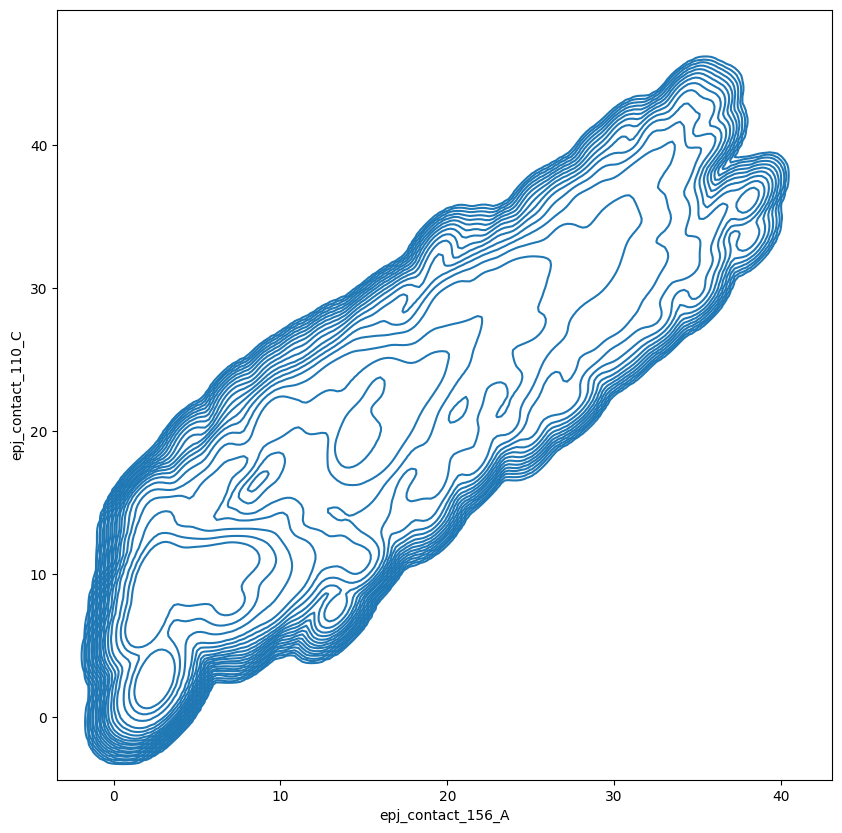

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))

levels = np.logspace(-10, -1, 20)
sns.kdeplot(data=feature_dataframe,
             x='epj_contact_156_A',
             y='epj_contact_110_C',
             weights='samp_weights',
             levels=levels,
             )

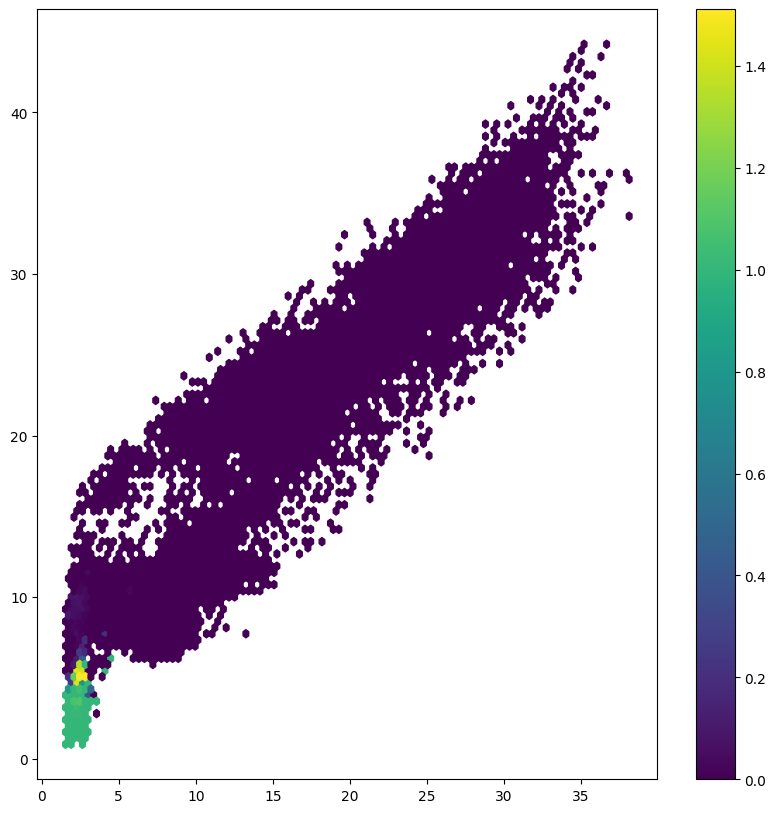

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

levels = np.logspace(-10, -1, 20)
mappable = ax.hexbin(
             x=feature_dataframe['epj_contact_156_A'].to_numpy(),
             y=feature_dataframe['epj_contact_110_C'].to_numpy(),
             C=feature_dataframe['water_bridge_108'].to_numpy(),
             )
plt.colorbar(mappable)

In [30]:
feature_dataframe['samp_weights'] = feature_dataframe['samp_weights'] / feature_dataframe['samp_weights'].sum()

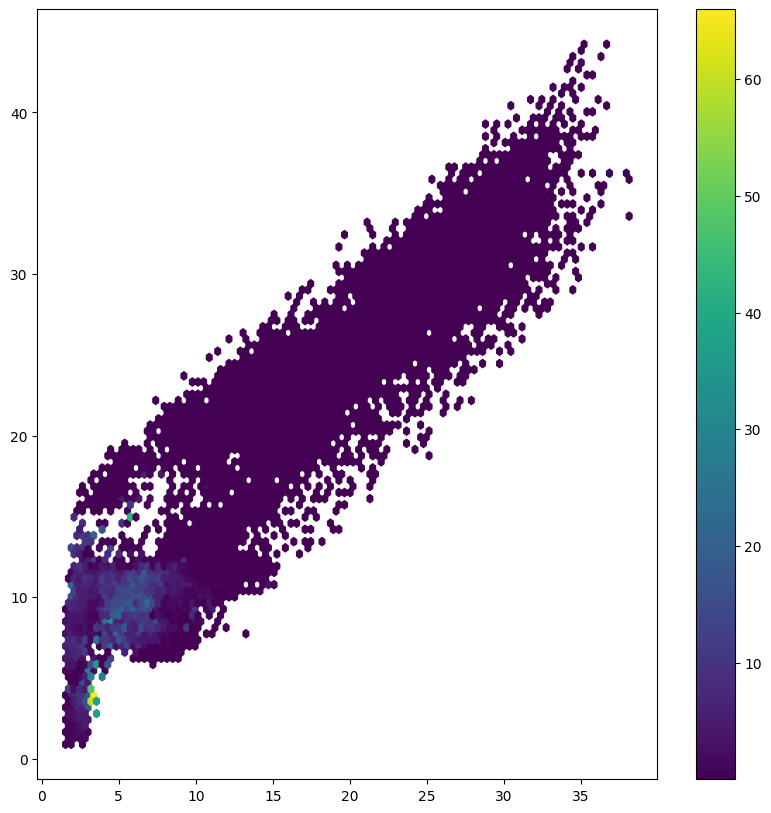

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))

msm_weight_bin = ax.hexbin(feature_dataframe['epj_contact_156_A'].to_numpy(),
                           feature_dataframe['epj_contact_110_C'].to_numpy(),
                           feature_dataframe['samp_weights'].to_numpy(),
                           gridsize=100)

plt.colorbar(msm_weight_bin)

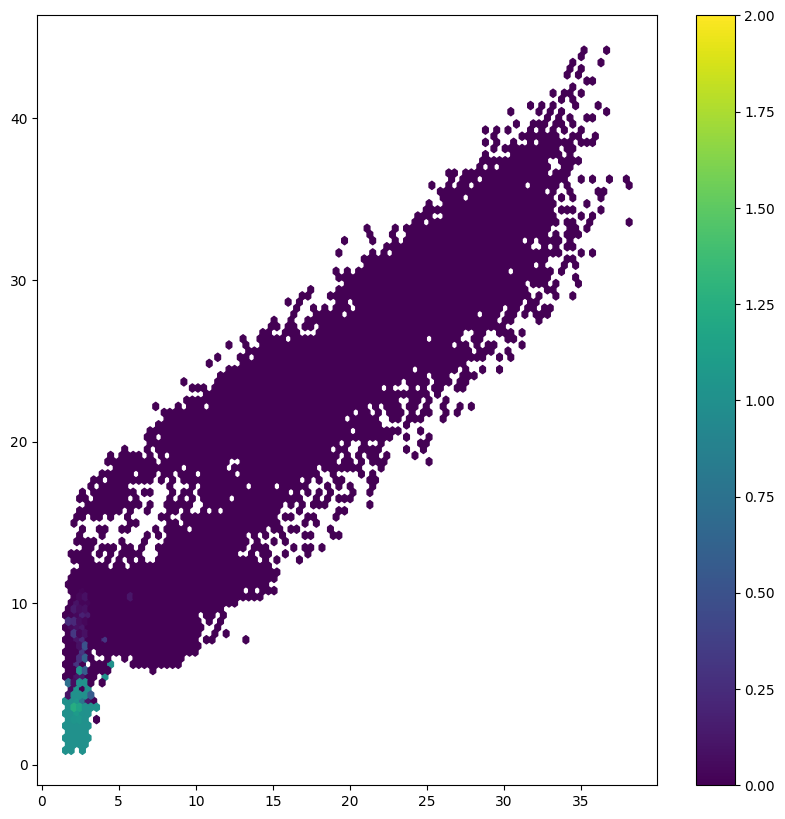

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

mappable = ax.hexbin(
             x=feature_dataframe['epj_contact_156_A'].to_numpy(),
             y=feature_dataframe['epj_contact_110_C'].to_numpy(),
             C=feature_dataframe['water_bridge_108'].to_numpy() * feature_dataframe['samp_weights'].to_numpy(),
             gridsize=100,
             vmin=0,
             vmax=2,
             )

mappable._A = mappable._A / msm_weight_bin._A
plt.colorbar(mappable)

<Axes: xlabel='epj1_pore', ylabel='loopc'>

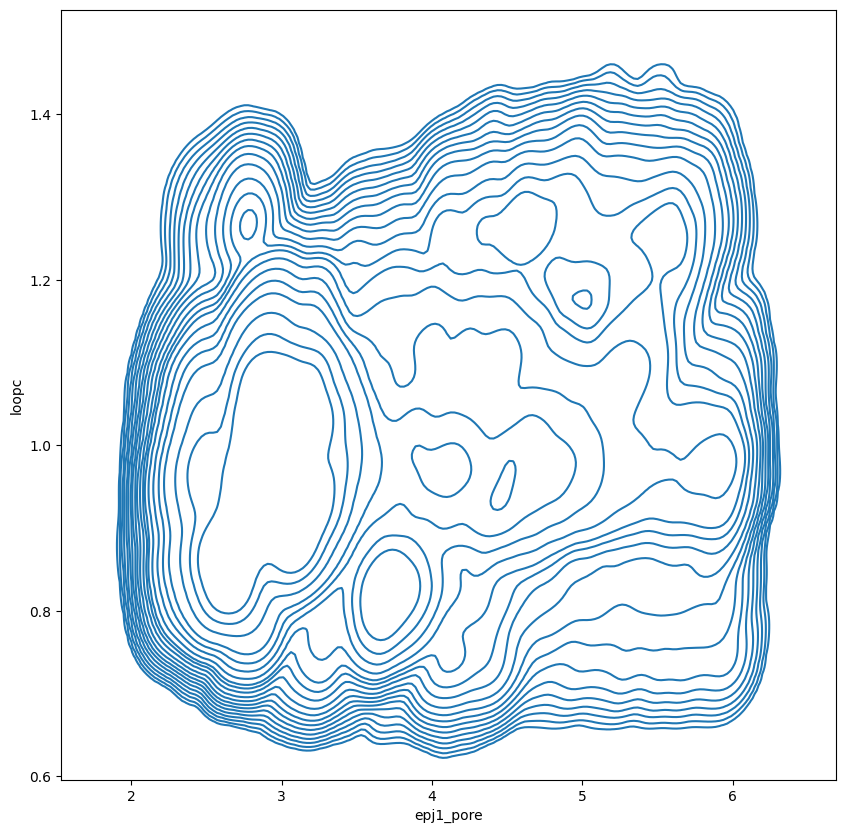

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))

levels = np.logspace(-10, -1, 20)
sns.kdeplot(data=feature_dataframe,
             x='epj1_pore',
             y='loopc',
             weights='samp_weights',
             levels=levels,
             )

Using GMM


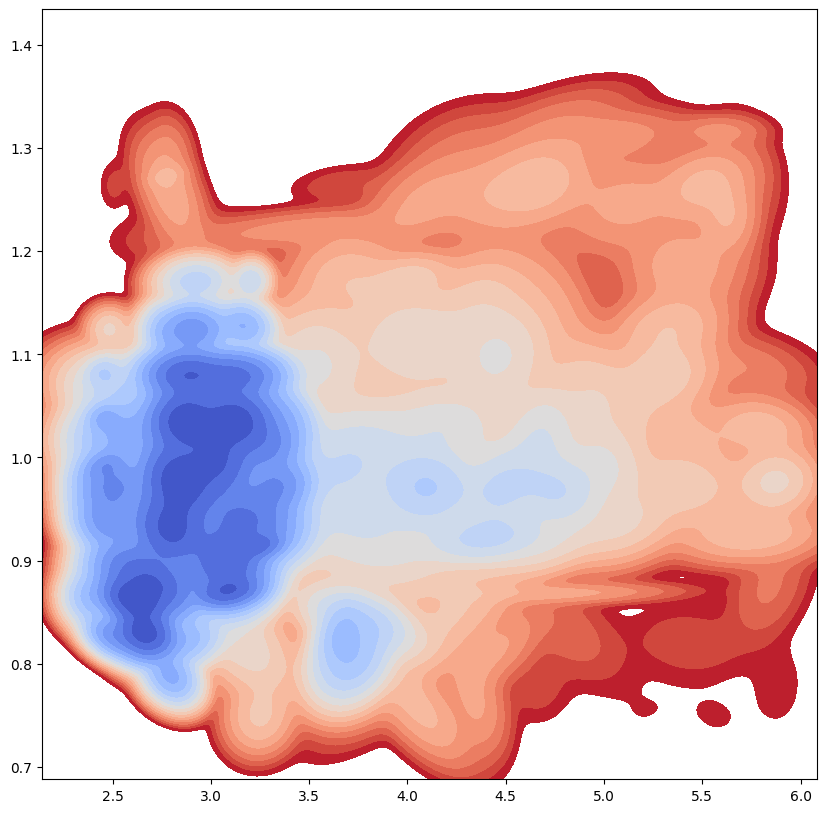

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
X_grid, Y_grid, dG = plot_pmf(
             X=feature_dataframe[['epj1_pore', 'loopc']].to_numpy(),
             weights=feature_dataframe['samp_weights'].to_numpy(),
             nclust=100,
             ax=ax,
             verbose=False)

Using GMM


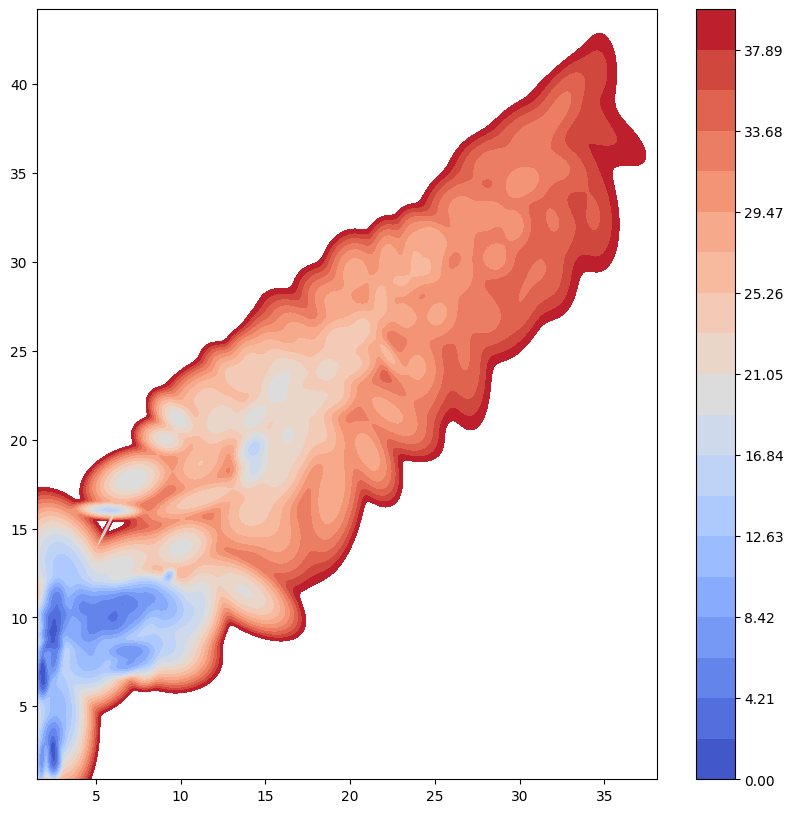

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
X_grid, Y_grid, dG = plot_pmf(
             X=feature_dataframe[['epj_contact_156_A', 'epj_contact_110_C',]].to_numpy(),
             weights=feature_dataframe['samp_weights'].to_numpy(),
             nclust=100,
             ax=ax,
             verbose=False)

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
X_sam, dG = plot_pmf(
             X=feature_dataframe[['epj1_pore']].to_numpy(),
             weights=feature_dataframe['samp_weights'].to_numpy(),
             nclust=100,
             ax=ax,
             gmm=True,
             verbose=False)

Using GMM
